### Classification



In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn

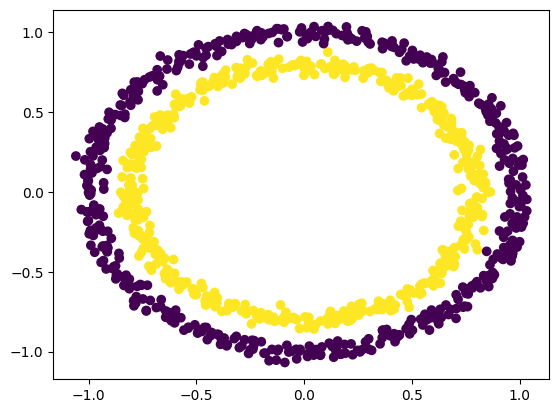

In [2]:
n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})

plt.scatter(x=X[:,0],
            y= X[:,1],
            c=y)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}")

X = torch.from_numpy(X).type(torch.float) # so they are classic float32 and not flaot64

y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

cuda


In [4]:
# Build a model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5,
                             out_features = 1)
  def forward(self,x):
    return(self.layer_2(self.layer_1(x)))


model_0 = CircleModelV0().to(device)
loss_fn = nn.BCEWithLogitsLoss() # If I use this, I don't have to put a sigmoid in the end! it does automatically

optimizer = torch.optim.SGD(model_0.parameters(), lr = 0.01)

def accuracy(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

epochs = 200

torch.manual_seed(42)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0.forward(X_train).squeeze()

  loss = loss_fn(y_logits.squeeze().to(device), y_train)
  acc = accuracy(y_train, torch.round(torch.sigmoid(y_logits)))
  if epoch % 100 == 0:
    print(f" Epoch {epoch} Accuracy in Train {acc}")

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode(): # with these 2 we enter testing mode
    y_pred_test = model_0.forward(X_test).squeeze()
    if epoch % 100 == 0:
      print(f"Accuract in Test: {accuracy(y_test, torch.round(torch.sigmoid(y_pred_test)))}")


 Epoch 0 Accuracy in Train 50.0
Accuract in Test: 50.0
 Epoch 100 Accuracy in Train 53.0
Accuract in Test: 51.5


Seems like is not learning anything...
the decision boundary is a line! We use only linear layer, maybe that's the problem?

### How to Improve Performances
- Add more layers
- Add more parameters in the layers
- More Epoch
- Change Activation Function
- Change Learning Rate


In [5]:
class CirclesModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10) # 10 instead of 5 parameters
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CirclesModelV1().to(device)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_1.parameters(), lr = 0.1)

torch.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train, y_pred)
  if epoch % 100 == 0:
    print(f" Epoch {epoch} Accuracy in Train {acc}")

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    y_logits_test = model_1.forward(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    acc = accuracy(y_test, y_pred_test)
    if epoch % 100 == 0:
      print(f" Epoch {epoch} Accuracy in Test {acc}")


 Epoch 0 Accuracy in Train 50.875
 Epoch 0 Accuracy in Test 51.0
 Epoch 100 Accuracy in Train 50.375
 Epoch 100 Accuracy in Test 48.0
 Epoch 200 Accuracy in Train 51.125
 Epoch 200 Accuracy in Test 46.0
 Epoch 300 Accuracy in Train 51.625
 Epoch 300 Accuracy in Test 45.0
 Epoch 400 Accuracy in Train 51.125
 Epoch 400 Accuracy in Test 46.0
 Epoch 500 Accuracy in Train 51.0
 Epoch 500 Accuracy in Test 46.0
 Epoch 600 Accuracy in Train 51.0
 Epoch 600 Accuracy in Test 46.0
 Epoch 700 Accuracy in Train 51.0
 Epoch 700 Accuracy in Test 46.0
 Epoch 800 Accuracy in Train 51.0
 Epoch 800 Accuracy in Test 46.0
 Epoch 900 Accuracy in Train 51.0
 Epoch 900 Accuracy in Test 46.0


We need non-linearity!

In [6]:
class CirclesModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 10) # 10 instead of 5 parameters
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) #Non linearity!!

def accuracy(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}")

loss_fn = nn.BCEWithLogitsLoss() # If I use this, I don't have to put a sigmoid in the end! it does automatically

model_2 = CirclesModelV2().to(device)

optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.1)

torch.manual_seed(42)

epochs = 1000



for epoch in range(epochs):
  model_2.train()
  y_logits = model_2.forward(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_train.to(device), y_pred)
  if epoch % 100 == 0:
    print(f" Epoch {epoch} Accuracy in Train {acc}")

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    y_logits_test = model_2.forward(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))
    acc = accuracy(y_test.to(device), y_pred_test)
    if epoch % 100 == 0:
      print(f" Epoch {epoch} Accuracy in Test {acc}")

cuda
 Epoch 0 Accuracy in Train 50.0
 Epoch 0 Accuracy in Test 50.0
 Epoch 100 Accuracy in Train 52.87500000000001
 Epoch 100 Accuracy in Test 52.5
 Epoch 200 Accuracy in Train 53.37499999999999
 Epoch 200 Accuracy in Test 55.00000000000001
 Epoch 300 Accuracy in Train 53.0
 Epoch 300 Accuracy in Test 56.00000000000001
 Epoch 400 Accuracy in Train 52.75
 Epoch 400 Accuracy in Test 56.49999999999999
 Epoch 500 Accuracy in Train 52.75
 Epoch 500 Accuracy in Test 56.49999999999999
 Epoch 600 Accuracy in Train 54.50000000000001
 Epoch 600 Accuracy in Test 56.00000000000001
 Epoch 700 Accuracy in Train 58.375
 Epoch 700 Accuracy in Test 59.0
 Epoch 800 Accuracy in Train 64.0
 Epoch 800 Accuracy in Test 67.5
 Epoch 900 Accuracy in Train 74.0
 Epoch 900 Accuracy in Test 79.0


### Let's put everything together in a multiclass classification problem

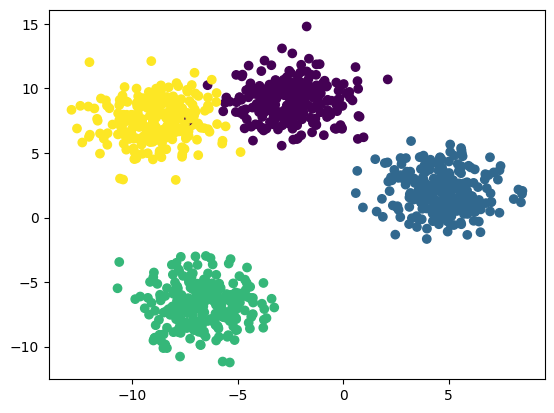

In [36]:
from sklearn.datasets import make_blobs


num_classes = 4
num_features = 2

X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = num_features,
                            centers= num_classes,
                            cluster_std = 1.5,
                            random_state = 42)

X_blob = torch.from_numpy(X_blob).type(torch.float32) # make_blobs make float64 !
y_blob = torch.from_numpy(y_blob).type(torch.float32)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob)

In [37]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """
    input_features = number of input features
    output_features = number of classes
    hidden_units = number of outputs/inpu between hidden layers
    """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


model_blob = BlobModel(input_features = 2, output_features = 4)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_blob.parameters(), lr = 0.1)

epochs = 100

torch.manual_seed(42)

for epoch in range(epochs):

  model_blob.train()
  y_logits = model_blob(X_blob_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train.long())
  acc = accuracy(y_blob_train, y_pred)
  if epoch % 10 == 0:
    print(f" Epoch {epoch} | Accuracy in Test {acc}")

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    y_logits_test = model_blob(X_blob_test)
    y_pred_test = torch.softmax(y_logits_test, dim = 1).argmax(dim=1)
    acc = accuracy(y_blob_test, y_pred_test)
    if epoch % 10 == 0:
      print(f" Epoch {epoch} | Accuracy in Test {acc}")

 Epoch 0 | Accuracy in Test 40.375
 Epoch 0 | Accuracy in Test 48.0
 Epoch 10 | Accuracy in Test 96.75
 Epoch 10 | Accuracy in Test 97.5
 Epoch 20 | Accuracy in Test 98.5
 Epoch 20 | Accuracy in Test 100.0
 Epoch 30 | Accuracy in Test 99.125
 Epoch 30 | Accuracy in Test 99.5
 Epoch 40 | Accuracy in Test 99.25
 Epoch 40 | Accuracy in Test 99.5
 Epoch 50 | Accuracy in Test 99.25
 Epoch 50 | Accuracy in Test 99.5
 Epoch 60 | Accuracy in Test 99.25
 Epoch 60 | Accuracy in Test 99.5
 Epoch 70 | Accuracy in Test 99.25
 Epoch 70 | Accuracy in Test 99.5
 Epoch 80 | Accuracy in Test 99.25
 Epoch 80 | Accuracy in Test 99.5
 Epoch 90 | Accuracy in Test 99.25
 Epoch 90 | Accuracy in Test 99.5


### Classification Metrics

* Accuracy
* Precision
* Recall
* F1
* Confusion Matrix
* Recall

In [38]:
#torch.metrics.Accuracy( ... )
#torch.metrics.Precision( ... )
#torch.metrics.Recall( ... )
#torch.metrics.F1score( ... )
sklearn.metrics.classification_report(y_blob_test, y_pred_test)

'              precision    recall  f1-score   support\n\n         0.0       0.98      1.00      0.99        49\n         1.0       1.00      1.00      1.00        41\n         2.0       1.00      1.00      1.00        53\n         3.0       1.00      0.98      0.99        57\n\n    accuracy                           0.99       200\n   macro avg       0.99      1.00      1.00       200\nweighted avg       1.00      0.99      1.00       200\n'